In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow INFO and WARNING messages

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


E0000 00:00:1732979126.363516  623412 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732979126.370520  623412 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

In [4]:
import tensorflow as tf
import keras
import pandas as pd
import os
import keras_cv
import matplotlib.pyplot as plt

In [5]:
csv_file = 'ham10000_data/HAM10000_metadata.csv'
img_dir = 'ham10000_data/images'
file_ext = '.jpg'

df = pd.read_csv(csv_file)

image_paths = [
    os.path.join(img_dir, image_id + file_ext)
    for image_id in df['image_id']
]

print(f"Number of images: {len(image_paths)}")
print(f"First 5 image paths: {image_paths[:5]}")

classes = sorted(df['dx'].unique())
num_classes = len(classes)

print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")

labels = df['dx'].map(lambda x: classes.index(x)).values
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

print(f"Class to Index Mapping: {class_to_idx}")
print(f"Labels: {labels}")

Number of images: 10015
First 5 image paths: ['ham10000_data/images/ISIC_0027419.jpg', 'ham10000_data/images/ISIC_0025030.jpg', 'ham10000_data/images/ISIC_0026769.jpg', 'ham10000_data/images/ISIC_0025661.jpg', 'ham10000_data/images/ISIC_0031633.jpg']
Number of classes: 7
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Class to Index Mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Labels: [2 2 2 ... 0 0 4]


In [6]:
def load_and_preprocess_image(image_id, label):
    # Load and preprocess the image
    image = tf.io.read_file(image_id)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))  # ResNet expects 224x224 images
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing for ResNet

    # One-hot encode the label
    label = tf.one_hot(label, depth=num_classes)

    return image, label


In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

train_paths = []
train_labels = []
val_paths = []
val_labels = []

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in sss.split(image_paths, labels):
    train_paths = [image_paths[i] for i in train_index]
    train_labels = labels[train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = labels[val_index]

print(f"Training set size: {len(train_paths)}")
print(f"Validation set size: {len(val_paths)}")

train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

Training set size: 8012
Validation set size: 2003


I0000 00:00:1732979130.655520  623412 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11139 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:0b:00.0, compute capability: 6.0
I0000 00:00:1732979130.656154  623412 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 15253 MB memory:  -> device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:13:00.0, compute capability: 6.0


In [8]:
batch_size = 32

train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()

val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache()


In [9]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
    keras.layers.RandomTranslation(0.1, 0.1),
])

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Compute class counts and class priors
class_counts = np.bincount(train_labels)
total_counts = np.sum(class_counts)
class_prior = class_counts / total_counts

# Clip class_prior to avoid log(0)
class_prior = np.clip(class_prior, 1e-7, 1.0)
output_bias = np.log(class_prior)

print(f"Class Counts: {class_counts}")
print(f"Class Prior: {class_prior}")
print(f"Output Bias: {output_bias}")

Class Counts: [ 262  411  879   92  890 5364  114]
Class Prior: [0.03270095 0.05129805 0.10971043 0.01148278 0.11108337 0.66949576
 0.01422866]
Output Bias: [-3.42035119 -2.97010248 -2.2099108  -4.46690712 -2.19747423 -0.40123045
 -4.25249725]


In [11]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    """
    Focal Loss for multi-class classification.

    Parameters:
    - gamma: Focusing parameter that adjusts the rate at which easy examples are down-weighted.
    - alpha: Balancing factor to balance the importance of different classes.

    Returns:
    - A loss function that can be used with multi-class classification models.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Compute cross entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Compute the focal loss weights
        loss_weight = alpha * K.pow(1 - y_pred, gamma)

        # Apply focal loss weights
        loss = loss_weight * cross_entropy

        # Sum over the last axis (the class axis)
        return K.sum(loss, axis=-1)

    return focal_loss_fixed


In [12]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply

def se_block(input_tensor, reduction_ratio=16, l2_regularization=0.01):
    filters = input_tensor.shape[-1]  # Get the number of channels
    se_shape = (1, 1, filters)

    # Squeeze: Global Average Pooling
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)

    # Excitation: Fully connected layers
    se = Dense(
        filters // reduction_ratio,
        activation='relu',
        kernel_initializer='he_normal',
        use_bias=False,
        kernel_regularizer=keras.regularizers.l2(l2_regularization)
    )(se)

    se = Dense(
        filters,
        activation='sigmoid',
        kernel_initializer='he_normal',
        use_bias=False,
        kernel_regularizer=keras.regularizers.l2(l2_regularization)
    )(se)

    # Scale: Multiply the input by the SE block output
    x = Multiply()([input_tensor, se])

    return x

In [ ]:
import tensorflow as tf
from tensorflow import keras


def build_resnet50_with_se(hp):
    inputs = tf.keras.Input(shape=(224, 224, 3))

    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling=None
    )

    base_model.trainable = False

    unfreeze_from = hp.Choice('unfreeze_from', values=[0, -10, -20, -50])
    if unfreeze_from is not None:
        for layer in base_model.layers[unfreeze_from:]:
            layer.trainable = True

    x = data_augmentation(inputs)
    x = base_model(x, training=unfreeze_from != 0)

    reduction_ratio = hp.Choice('reduction_ratio', values=[4, 8, 16, 32])
    l2_regularization = hp.Choice('l2_regularization', values=[0.01, 0.001, 0.0001])

    x = base_model.get_layer("conv2_block3_out").output
    x = se_block(x, reduction_ratio=reduction_ratio, l2_regularization=l2_regularization)

    x = base_model.get_layer("conv3_block4_out").output
    x = se_block(x, reduction_ratio=reduction_ratio, l2_regularization=l2_regularization)

    x = base_model.get_layer("conv4_block6_out").output
    x = se_block(x, reduction_ratio=reduction_ratio, l2_regularization=l2_regularization)

    x = base_model.get_layer("conv5_block3_out").output
    x = se_block(x, reduction_ratio=reduction_ratio, l2_regularization=l2_regularization)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    dropout_rate = hp.Choice('dropout_rate', values=[0.2, 0.3, 0.5])
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    output_bias = np.log(np.ones((num_classes,)) / num_classes)
    outputs = tf.keras.layers.Dense(
        num_classes,
        activation='softmax',
        bias_initializer=tf.keras.initializers.Constant(output_bias),
        kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_regularization_output', values=[0.01, 0.001, 0.0001]))
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    weight_decay = hp.Choice('weight_decay', values=[1e-2, 1e-3, 1e-4])
    optimizer_choice = hp.Choice('optimizer', values=['adamw', 'sgd'])

    if optimizer_choice == 'adamw':
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    else:
        momentum = hp.Choice('momentum', values=[0.8, 0.9, 0.99])
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, weight_decay=weight_decay)

    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=hp.Choice('gamma', values=[0.5, 1.0, 2.0]), alpha=hp.Choice('alpha', values=[0.25, 0.5, 0.75])),
        metrics=[
            tf.keras.metrics.AUC(name='auc', multi_label=False),
            'accuracy'
        ]
    )

    return model

In [14]:
from sklearn.utils import class_weight
import numpy as np


class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_dict = dict(enumerate(class_weights))

In [15]:
import keras_tuner as kt

from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True)


# Create a tuner
tuner = kt.Hyperband(
    build_resnet50_with_se,
    objective='val_auc',
    max_epochs=50,
    factor=3,
    directory='se_block_residual_3',
    project_name='hyperparameter_tuning'
)

# Perform the search
tuner.search(
  train_dataset,
  validation_data=val_dataset,
  epochs=50,
  class_weight=class_weights_dict,
  callbacks=[early_stopping]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)


Reloading Tuner from se_block_residual_3/hyperparameter_tuning/tuner0.json
Best Hyperparameters: {'unfreeze_from': -50, 'reduction_ratio': 8, 'l2_regularization': 0.01, 'dropout_rate': 0.3, 'l2_regularization_output': 0.01, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'optimizer': 'adamw', 'gamma': 2.0, 'alpha': 0.5, 'momentum': 0.9, 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 3, 'tuner/round': 2, 'tuner/trial_id': '0035'}


In [16]:
import numpy as np


callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=12,
        min_delta=1e-4,
        restore_best_weights=True,
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.1,
        patience=4,
        min_lr=1e-7,
        mode='max'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='best_models/resnet50-seblock-residual.keras',
        monitor='val_auc',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    )
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    callbacks=callbacks,
    class_weight=class_weights_dict,
)

Epoch 1/500


I0000 00:00:1732979151.074053  623491 service.cc:148] XLA service 0x791ee0001d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732979151.074089  623491 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732979151.074093  623491 service.cc:156]   StreamExecutor device (1): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732979153.998317  623491 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/251 ━━━━━━━━━━━━━━━━━━━━ 2:23:39 34s/step - accuracy: 0.1250 - auc: 0.4307 - loss: 46.8201

I0000 00:00:1732979168.129232  623491 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.4879 - auc: 0.8212 - loss: 41.9026
Epoch 1: val_auc improved from -inf to 0.94802, saving model to best_models/resnet50-seblock-residual.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 191ms/step - accuracy: 0.4883 - auc: 0.8215 - loss: 41.8850 - val_accuracy: 0.7034 - val_auc: 0.9480 - val_loss: 29.3154 - learning_rate: 1.0000e-04
Epoch 2/500
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7459 - auc: 0.9589 - loss: 26.0121
Epoch 2: val_auc improved from 0.94802 to 0.96064, saving model to best_models/resnet50-seblock-residual.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.7461 - auc: 0.9590 - loss: 25.9893 - val_accuracy: 0.7544 - val_auc: 0.9606 - val_loss: 17.9975 - learning_rate: 1.0000e-04
Epoch 3/500
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8511 - auc: 0.9844 - loss: 15.9034
Epoch 3: val_auc improved from 0.96064 to 0.97323, saving model to best_models/resnet50-seblock-residual.keras
251/251 ━

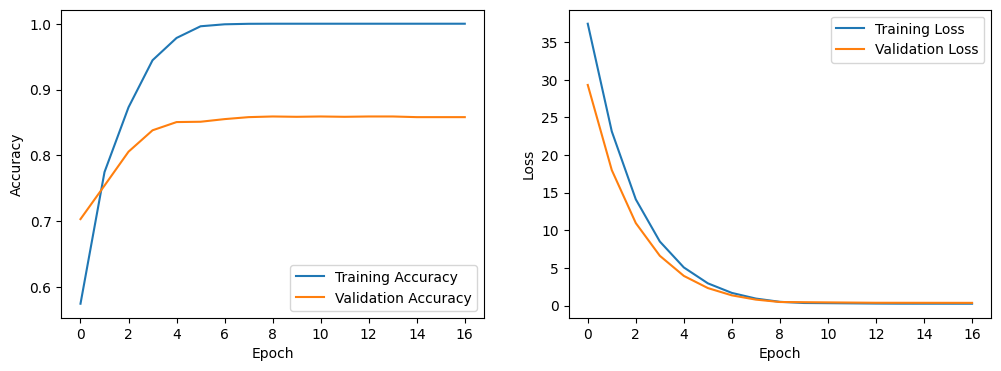

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

y_true = []
y_pred = []

def get_predictions(dataset):
    for images, labels in dataset:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
    return np.array(y_true), np.array(y_pred)

# Get predictions for validation dataset
y_true, y_pred = get_predictions(val_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━

In [19]:
# Classification Report

y_true = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true
y_pred = np.argmax(y_pred, axis=1) if y_pred.ndim > 1 else y_pred

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

       akiec       0.64      0.72      0.68        65
         bcc       0.75      0.75      0.75       103
         bkl       0.84      0.60      0.70       220
          df       0.67      0.61      0.64        23
         mel       0.60      0.69      0.64       223
          nv       0.92      0.94      0.93      1341
        vasc       0.83      0.86      0.84        28

    accuracy                           0.85      2003
   macro avg       0.75      0.74      0.74      2003
weighted avg       0.85      0.85      0.85      2003



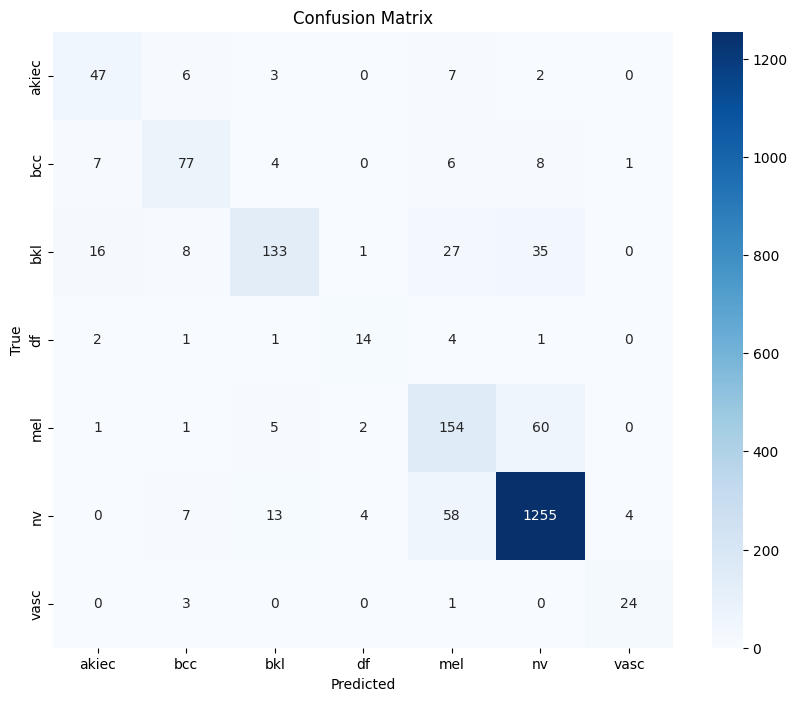

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

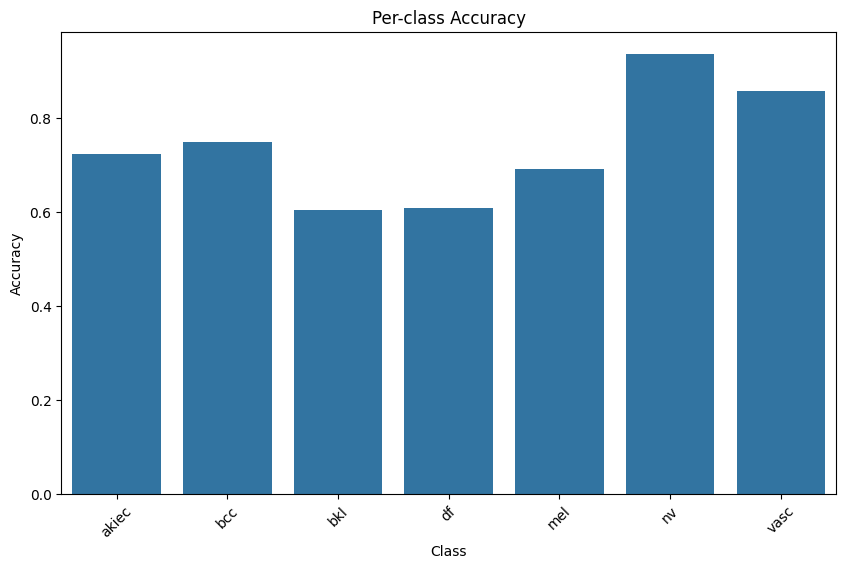

In [21]:
# Per-class Accuracy Plot
class_accuracies = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=class_accuracies)
plt.title('Per-class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()